# Project Overview

## Objective

## Performance Criteria

## Hypothesis

## Assumptions & Exclusions

# Setup

In [45]:
import pandas as pd
import numpy as np
import os
import scikitplot as skplt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from future_encoders import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

# To serialise models
from sklearn.externals import joblib

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

pd.set_option('display.max_columns', 60)

import seaborn as sns
sns.set(font_scale = 2)
sns.set()

# to make this notebook's output stable across runs
np.random.seed(42)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    if not os.path.isdir(IMAGES_PATH):
        os.makedirs(IMAGES_PATH)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


PROCESSED_PATH = os.path.join(PROJECT_ROOT_DIR, "processed")
def save_processed(df, filename, extension="csv"):
    if not os.path.isdir(PROCESSED_PATH):
        os.makedirs(PROCESSED_PATH)
    path = os.path.join(PROCESSED_PATH, filename + "." + extension)
    print("Saving processed dataset", filename)
    df.to_csv(path, index=False)
    
SUBMISSIONS_PATH = os.path.join(PROJECT_ROOT_DIR, "submissions")
def save_submission(df, filename, extension="csv"):
    if not os.path.isdir(SUBMISSIONS_PATH):
        os.makedirs(SUBMISSIONS_PATH)
    path = os.path.join(SUBMISSIONS_PATH, filename + "." + extension)
    print("Saving submission", filename)
    df.to_csv(path, index=False)

MODELS_PATH = os.path.join(PROJECT_ROOT_DIR, "models")
def store_model(model, filename):
    if not os.path.isdir(MODELS_PATH):
        os.makedirs(MODELS_PATH)
    path = os.path.join(MODELS_PATH, filename + "." + "pkl")
    print("Saving model", filename)
    joblib.dump(model, path)
    
# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")

# Get Data

In [2]:
import os
import tarfile
from six.moves import urllib

def fetch_data(base_url, file_name, remote_sub_dir=None, file_ext="csv", base_local_path = "raw", local_store_sub_dir=None):
    '''
    Downloads file_name.file_ext from base_url & optional remote_sub_dir and stores it in relative base_local_path & 
    optional local_store_sub_dir. If file is a tarball, it will be extracted as well. 
    
    Issues: doesn't work with .csv.gz files
    '''
    if remote_sub_dir is not None:
        download_url = base_url + remote_sub_dir + file_name + "." + file_ext
    else:
        download_url = base_url + file_name + "." + file_ext
    
    if not os.path.isdir(base_local_path):
         os.makedirs(base_local_path)
            
    if local_store_sub_dir is not None:
        local_path = os.path.join(base_local_path, local_store_sub_dir)
        if not os.path.isdir(local_path):
            os.makedirs(local_path)
    else:
        local_path = os.path.join(base_local_path)
    
    
    full_file_name = file_name + "." + file_ext
    file_path = os.path.join(local_path, full_file_name)
    
    print("Downloading file:", full_file_name)
    urllib.request.urlretrieve(download_url, file_path)
    
    if file_ext in ["tgz", "tar", "gz", "tar.gz"]:
        data_tgz = tarfile.open(file_path)
        data_tgz.extractall(path=local_path)
        data_tgz.close()

In [1213]:
filenames = ["train", "test", "sample_submission", "data_description"]
extensions = ["csv", "csv", "csv", "txt"]

for file, ext in zip(filenames, extensions):
    fetch_data(base_url = "https://raw.githubusercontent.com/dorond/kaggle-house-prices-prediction/master/", 
           file_name = file, 
           remote_sub_dir="raw/", 
           file_ext=ext)

In [3]:
def load_data(base_path, file, sub_dir=None, ext="csv", encoding=None):
    filename = file + "." + ext
    if sub_dir is not None:
        csv_path = os.path.join(base_path, sub_dir, filename)
    else:
        csv_path = os.path.join(base_path, filename)
    return pd.read_csv(csv_path)

In [4]:
base_path = "raw/"
train = load_data(base_path, "train")
test = load_data(base_path, "test")

# Explore the Data

In [5]:
train["source"] = "train"
test["source"] = "test"
data = pd.concat([train, test], ignore_index=True, sort=False)
print (train.shape, test.shape, data.shape)

(1460, 82) (1459, 81) (2919, 82)


Let's create a function `explore_variable` that will make it easier for us to visualise single features as well as correlation with a target feature.

In [6]:
# Used to explore a single feature on a set of subplots. 
# Visualise distribution, noise & outliers and missing values as well as correlation with target.
def explore_variable(df, feature, target, by_categorical=None):
    '''
    Numerical features will display 3 plots: histogram, correlation between source feature and a target and a box plot for feature. 
    Optional by_categorical can be provided to show box plot by levels of a categorical variable.
    Categorical features will display 2 plots: bar chart of levels, median of target by feature levels.
    '''    
    feature_type = df[feature].dtype
    missing = df.apply(lambda x: sum(x.isnull())).loc[feature]
    print("'{}' is of type {} with {} missing values".format(feature, feature_type, missing))

    if feature_type == "object":
        fig, ax = plt.subplots(1, 2, figsize=(15,5))
        fig.subplots_adjust(wspace=0.3)

        ax1 = ax.ravel()[0]
        ax1.set_title("Distribution of {}".format(feature))
        df[feature].value_counts().plot.barh(ax=ax1)

        ax2 = ax.ravel()[1]
        ax2.set_title("Median {} by {}".format(target, feature))
        df.groupby(feature)[[target]].median().plot.barh(ax=ax2)

        plt.show()

    elif feature_type == "int64" or "float64":
        fig, ax = plt.subplots(1, 3, figsize=(15,5))
        fig.subplots_adjust(wspace=0.3)

        ax1 = ax.ravel()[0]
        ax1.set_title("Distribution of {}".format(feature))
        df[feature].hist(bins=50, ax=ax1)

        ax2 = ax.ravel()[1]
        ax2.set_title("Correlation between {} and {}".format(feature, target))
        df.plot.scatter(x=feature, y=target, ax=ax2)  

        ax3 = ax.ravel()[2]
        ax3.set_title("Box plot for {}".format(feature))
        #df[feature].plot.box(ax=ax3)
        if by_categorical is not None:
            sns.boxplot(x=by_categorical, y=feature, data=df, ax=ax3)
        else:
            sns.boxplot(y=df[feature], ax=ax3)
        

        plt.show()


## Variable Types

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

- `MSSubClass` identified as numeric but its actually an ordinal categorical variable. Will be transformed later. 

## Missing Values

In [8]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [9]:
missing_values_table(train)

Your selected dataframe has 82 columns.
There are 19 columns that have missing values.


,Missing Values,% of Total Values
PoolQC,1453,99.5
MiscFeature,1406,96.3
Alley,1369,93.8
Fence,1179,80.8
FireplaceQu,690,47.3
LotFrontage,259,17.7
GarageType,81,5.5
GarageYrBlt,81,5.5
GarageFinish,81,5.5
GarageQual,81,5.5


- Although `PoolQC`, `MiscFeature`, `Alley`, `Fence` and `FireplaceQu` have a lot of missing values, the data dictionary indicates that a valid level was `No Fireplace` or `No Alley`. This is different from a missing value and will be treated by imputing a more suitable value.
- Automated pipelines will later allow us to trial different imputation strategies, namely mean and median for numerical variables and most common for categorical variables, thus we won't remove any rows or columns with missing values at this stage. 

## Distributions, Correlations & Outliers

We'll perform a basic histogram plot of all numerical variables now and leave the relationships across categorical variables for later.

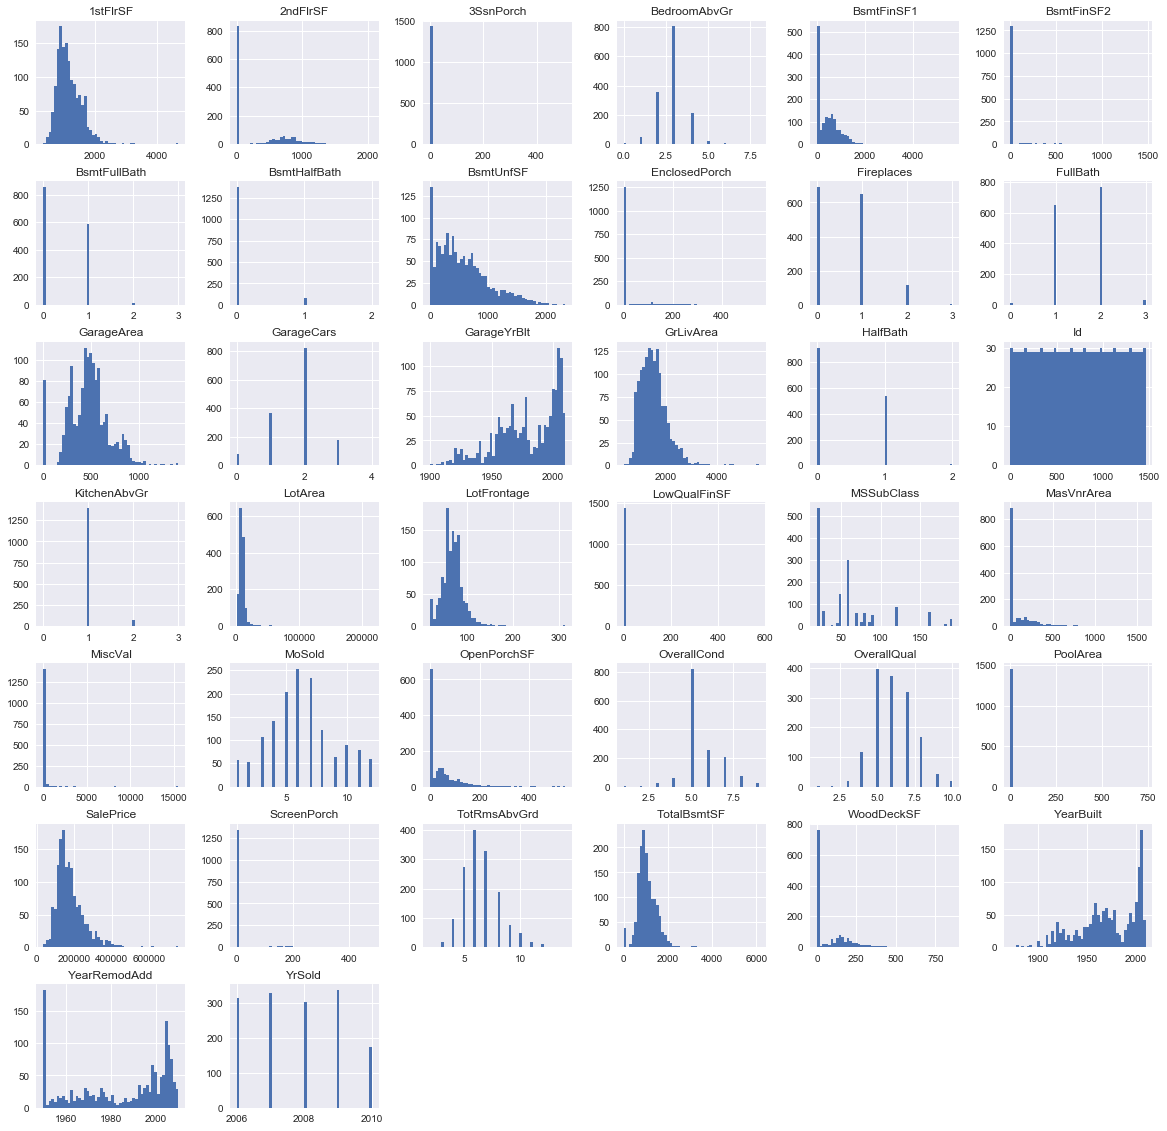

In [10]:
train.hist(bins=50, figsize=(20, 20))
plt.show()

- Features have different scales, we'll need to standardize or normaise these.
- There are a lot of 0 values, especially with the discrete variables. This is not a problem since its expected that not all properties will have all options.
- Axis transformations (log, sqrt etc.) might be useful
- `YearsRemodAdd` has a high number of properties on year zero. However if no remods or additions have been made, then this value is the same as construction date. This likely skews the data as it gives an inaccurate representation of when remodelling has happened. 
- A lot of properties seemt to be built in the late 2000's, this might point to interesting trends in the city.
- A few of the distributions are skewed so may need to apply column transformation in order to make their distribution more normal.

Let's take a deeper look at our target variable `SalePrice`

'SalePrice' is of type int64 with 0 missing values


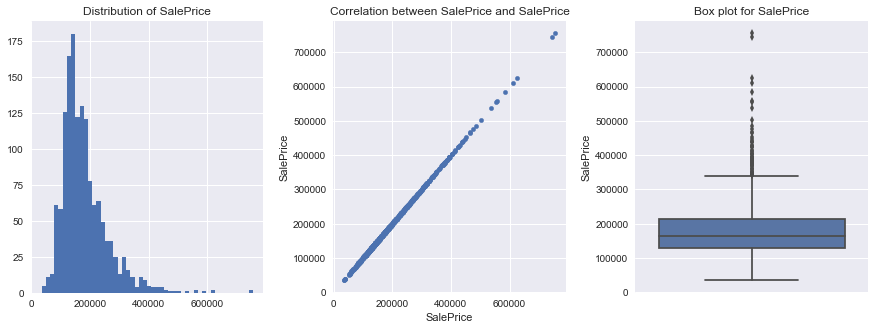

In [11]:
explore_variable(train, "SalePrice", "SalePrice")

The middle 50% of sales prices are between \$130K and \$210K with a median around \$150K. There are some outliers exceeding 600K which we can investigate. 

In [12]:
train[train["SalePrice"] > 600000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,...,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,source
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,...,1,Ex,10,Typ,2,Ex,Attchd,1994.0,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000,train
898,899,20,RL,100.0,12919,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,9,5,2009,2010,Hip,CompShg,VinylSd,VinylSd,Stone,760.0,Ex,TA,PConc,...,1,Ex,11,Typ,2,Gd,Attchd,2009.0,Fin,3,820,TA,TA,Y,0,67,0,0,0,0,NaN,NaN,NaN,0,3,2010,New,Partial,611657,train
1169,1170,60,RL,118.0,35760,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1995,1996,Hip,CompShg,HdBoard,HdBoard,BrkFace,1378.0,Gd,Gd,PConc,...,1,Gd,10,Typ,1,TA,Attchd,1995.0,Fin,3,807,TA,TA,Y,361,76,0,0,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal,625000,train
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,...,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000,train


These appear to be in `MSSubClass` 60 (2-STORY 1946 & NEWER) and 20 (1-STORY 1946 & NEWER ALL STYLES) in the Northridge and Northridge Heights neighbourhoods respectively. All the Northridge properties were built between 1994 - 1996 and are on large lot areas. We may want to remove these outliers in order for our models to perform better. These will be treated as hyperparameters during model tuning.

Let's take a look at how sales price varies amonst different neighbourhoods and house styles

'Neighborhood' is of type object with 0 missing values


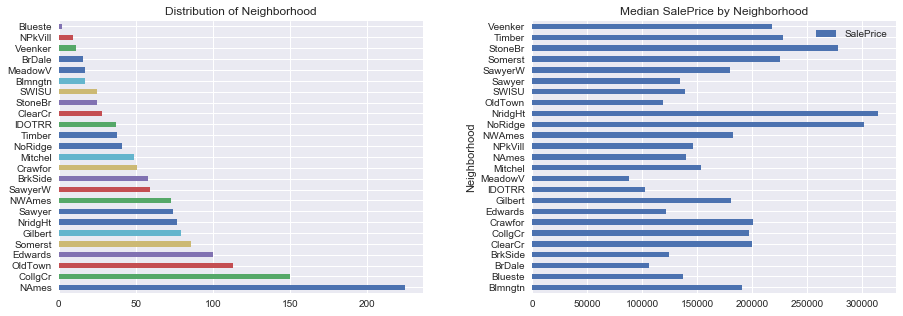

In [13]:
explore_variable(train, "Neighborhood", "SalePrice")

The greatest number of properties come from North Ames, College Creek and Old Town while the highest median sales prices are in Northridge, Northridge Heights (as previously identified) and Stone Brook. 

'HouseStyle' is of type object with 0 missing values


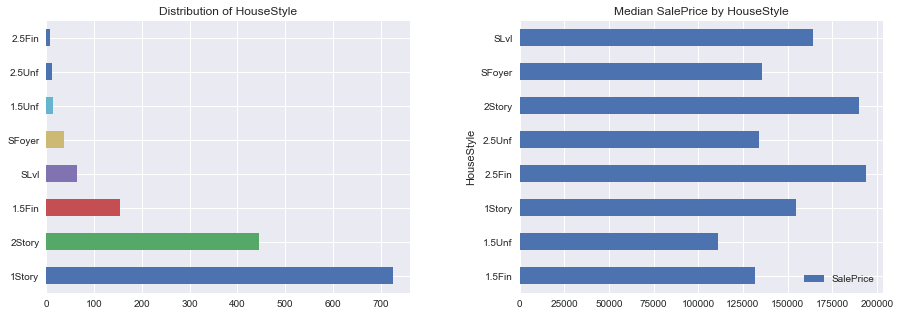

In [14]:
explore_variable(train, "HouseStyle", "SalePrice")

Single and Double story houses are the most common and double and 2.5 story houses get the highest selling price.

Let's get a high level overview of correlations with our sales price.

In [15]:
corr_matrix = train.corr()["SalePrice"]

Let's take a look at the 10 most positively and negatively correlated features.

In [16]:
top10_pos_corr = corr_matrix.sort_values(ascending=False)[:10]
top10_pos_corr

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

Quite a few features have a strong positive correlation with `SalePrice`. We'll investigate this more thoroughly shortly.

In [17]:
top10_neg_corr = corr_matrix.sort_values(ascending=True)[:10]
top10_neg_corr

KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
MSSubClass      -0.084284
OverallCond     -0.077856
YrSold          -0.028923
LowQualFinSF    -0.025606
Id              -0.021917
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
Name: SalePrice, dtype: float64

Nagative correlations aren't as strong however it is interesting that the number kitchens above ground would negatively correlate. It's important to bear in mind that these correlation values only reflect possible linear relationships. We'll perform pair-wise scatter plots shortlly which will give us a better idea of any non-linear relationships. Later we'll consider `log` and `sqrt` transformations of some columns.

In [18]:
corr_features = top10_pos_corr[1:6].index.values.tolist() + top10_neg_corr[:5].index.values.tolist()
corr_features

['OverallQual',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'TotalBsmtSF',
 'KitchenAbvGr',
 'EnclosedPorch',
 'MSSubClass',
 'OverallCond',
 'YrSold']

In [19]:
def plot_scatters(df, features, target):
    
    num_plots = len(features)
    num_cols = 2
    num_rows = int(np.ceil(num_plots / num_cols))
    
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(20, 25))
    fig.subplots_adjust(hspace=0.4, wspace=0.2)

    for ax, feature in zip(ax.ravel(), features):
        df.plot.scatter(x=feature, y=target, ax=ax)
           

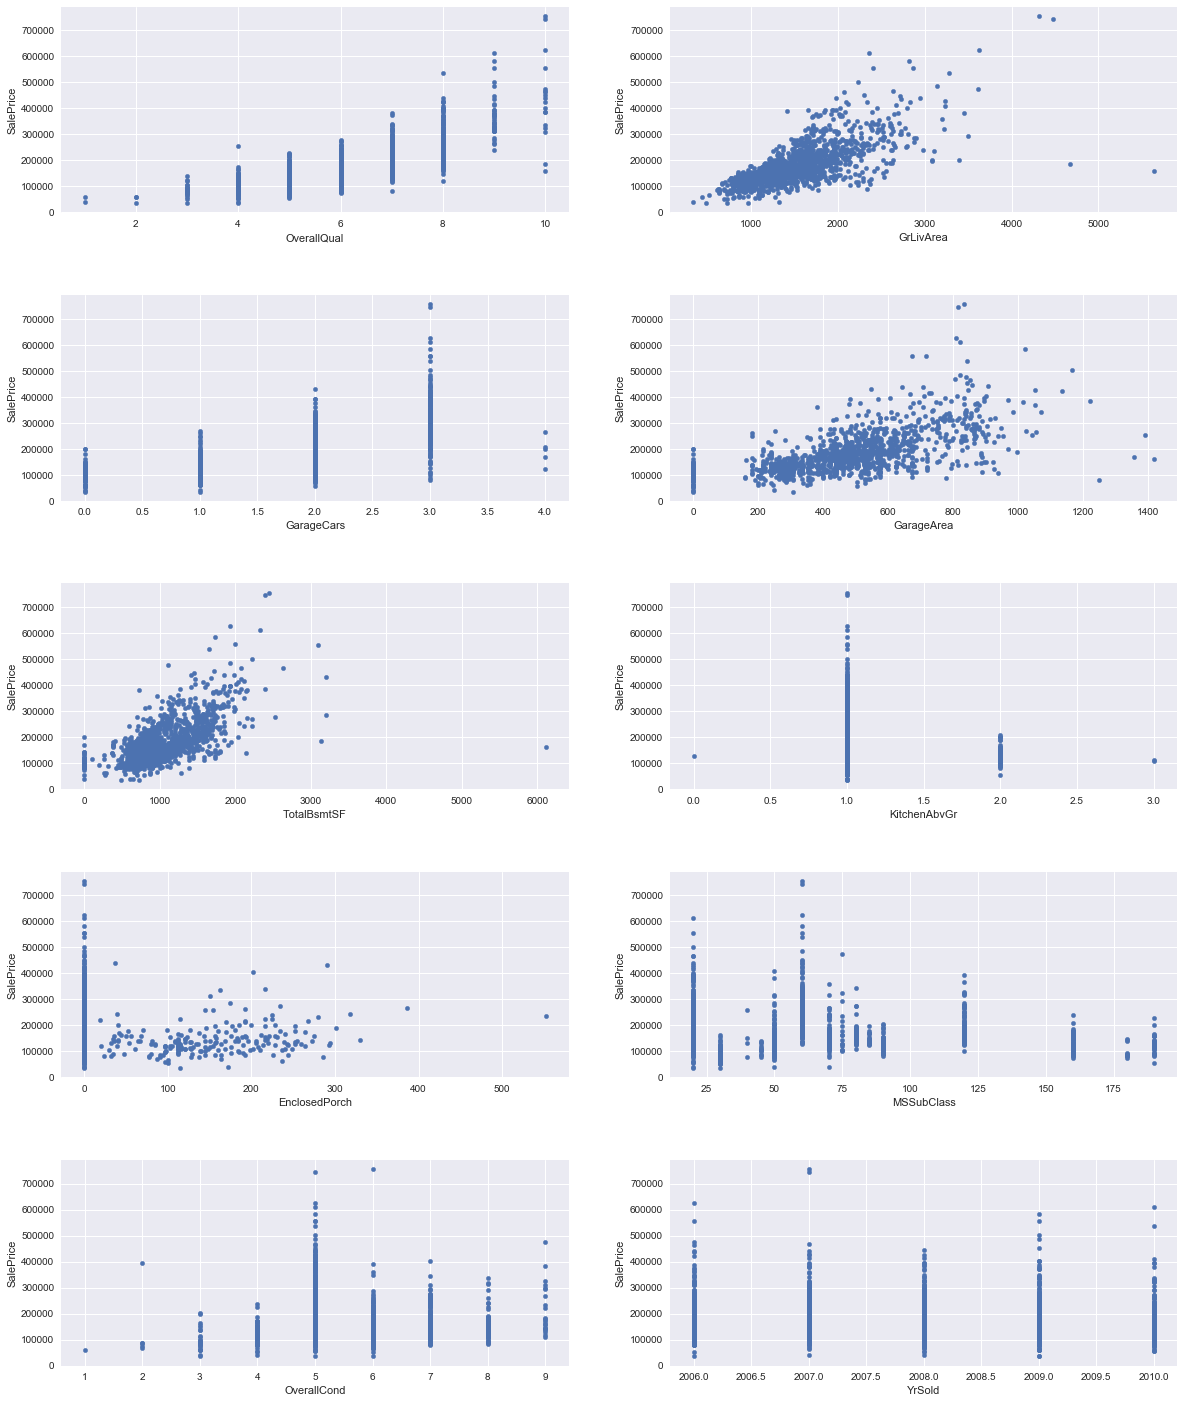

In [20]:
plot_scatters(train, corr_features, "SalePrice")

- As one would expect, as the overall quality of the property goes up, so does the sales price.
- Interesting that an overall condition of 5 seems to attract sales prices across the board and even the highest selling price. Could be an error.
- One property seems to have a huge enclosed porch (outlier), this could be a data entry error. 

## Identify Transformations

The datat exploration done above wasn't intended to be complete. It's aim was to give us a feel for the data before applying transformations. We'll test out different imputing strategies, column transformations and handling of outliers when we tune our models. We'll build our pipeline in such a way that we can treat all of these as hyperparameter options.

The following transformations will be performed
- Categorical fields that allow for values such as `No alley access` or `No Basement` were given value `NA` which pandas identified as a missing value when performing the import. We'll provide these with their origin value so that when we perform one-hot encoding, we don't miss out on this useful bit of info.
- Missing values for other categorical variables will be filled in with the most common value
- Missing numerical values with be imputed with either the mean or median, both will be tested.
- We'll apply three outlier strategies: Don't remove any, remove those greater than **$\pm$ 1.5 x Inter-Quartile Range (IQR)**, remove those greater than **$\pm$ 3 (IQR)**
- `log` and `sqrt` transformations will be tested on certain columns.

# Prepare the Data
During this stage we will create a variety of transformers and functions that will allow us to easily clean data, select features and create new features. These transformation pipelines will be used whenever we want to try out different feature/hyperparameter options. 

## Building Pipeline Functions

Now we need to build a few custom imputers and estimators to handle various situations:

- `MostFrequentImputer` will be used to find the most common value in a categorical column and use that for missing values.
- `OutlierRemover` will be used to remove outliers that fall in a specified range.
- `ApplyNACategory` will apply the correct label (such as `No Basement`) to columns that were incorrectly marked as `np.nan` 
- `ApplyFeatureTransform` will apply a log, sqrt or power function to the specified features.
- `DataFrameSelector` will allow us to select either numerical or categorical columns from a pandas dataframe and covert it for use with scikit-learn.
- `TypeSelector` allows us to select columns of a specific type from a dataframe. We can choose all columns or a selection by passing in the appropriate values.
- `TopFeatureSelector` will allow us to choose a selection of the top performing features before further applying the pipeline.
- `CombinedAttributesAdder` adds new features we create to the pipeline, as well as allowing use to include/exclude specific features as hyperparameter choices.
- `InfImputer` replaces all `np.inf` or `-np.inf` values with `np.nan`. It is important that there are no infinity values before we attempt standard scaling of the data.
- `determine_one_hot_cat_features` will be used during model fitting and evaluation. It will allow us to determine all the generated categorical features that have been created in the pipeline procecss. We can pass these to our model measurements function `measure_regression_model` which uses this for plotting purposes. 
- `build_run_model` allows to build a pipeline for processing numerical, boolean and categorical features and it executes CV based on specified parameters. It allows one to easily test different model ideas, feature selections and parameter tuning, all while making use of scikit-learn's robust pipeline infrastructure. 
- `measure_regression_model` can be run on a model once CV has been completed. It does three things:  
    - Shows high-level statstics for CV included the mean, standard deviation, min and max CV scores.
    - Plots the features importances as derived from CV.
    - Plots a learning curve
    - Returns a sorted dataset with the original values, target feature and predictions, sorted by worst performing rows, descending. This can be used for furuther analysis. 

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin
# Inspired from stackoverflow.com/questions/25239958

class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X], index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [22]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, outlier_params):
        self.features = outlier_params["features"]
        self.irq_ranges = outlier_params["range"]
        self.remove_lows = outlier_params["remove_lows"]
        self.remove_highs = outlier_params["remove_highs"]
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):     
                
        first_quartile = X.describe().loc["25%"]
        third_quartile = X.describe().loc["75%"]
        iqr = third_quartile - first_quartile
                      
        # find rows subset that should be removed for each feature and irq range
        # Perform boolean AND to decide if row is to be removed - at least one True is needed.
        
        row_filters = []
        for feature, iqr_multiplier, remove_low, remove_high in zip(self.features, self.irq_ranges, self.remove_lows, self.remove_highs):
            
            if remove_low and remove_high: 
                low_high_filter = (X[feature] > (first_quartile[feature] - iqr_multiplier * iqr[feature])) &(X[feature] < (third_quartile[feature] + iqr_multiplier * iqr[feature]))
                row_filters.append(low_high_filter)
               
            
            elif remove_low and not remove_high:
                row_filters.append(X[feature] > (first_quartile[feature] - iqr_multiplier * iqr[feature]))
                
            elif not remove_low and remove_high:
                row_filters.append(X[feature] < (third_quartile[feature] + iqr_multiplier * iqr[feature]))
                
            else:
                pass
        
        row_filter = row_filters[0]        
        for option in row_filters[1:]:
            row_filter = row_filter & option
        
        return X[row_filter]


In [23]:
class ApplyNACategory(BaseEstimator, TransformerMixin):
    def __init__(self, na_dict):
        self.na_dict = na_dict
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.fillna(value=self.na_dict)

In [24]:
class ApplyFeatureTransform(BaseEstimator, TransformerMixin):
    def __init__(self, feature_transform_params):
        self.features = feature_transform_params["features"]
        self.transformations = feature_transform_params["operations"]
        self.col_prefixes = feature_transform_params["prefixes"]
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        for feature, transform, prefix in zip(self.features, self.transformations, self.col_prefixes):
            col_name = prefix + "_" + feature
            X[col_name] = X[feature].apply(transform)
        return np.c_[X]

In [25]:
# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [26]:
class TypeSelector(BaseEstimator, TransformerMixin):
    '''
    Select features of a specific type. if choose='all' then all features of that type will be selected and features will have no affect.
    If choose='select' then features mujst contain a list of features matching dtype
    '''
    def __init__(self, dtype, choose="all", features=None):
        self.dtype = dtype
        self.choose = choose
        self.features = features
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.choose == "all":
            return X.select_dtypes(include=[self.dtype])
        elif self.choose == "select":
            if self.features is not None:
                return X.select_dtypes(include=[self.dtype])[self.features]
                
            else:
                raise ValueError('features must contain a list of features of type', self.dtype, 'if choose="select"')
        

In [27]:
def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [28]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, feature_adder_params): # no *args or **kargs
        self.base_features_ids = feature_adder_params["base_features_ids"]
        self.operations = feature_adder_params["operations"]
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        new_features = []        
        for base_ids, operation in zip(self.base_features_ids, self.operations):            
            new_features.append(operation(X[:, base_ids[0]], X[:, base_ids[1]]))        
        
        for feature in new_features:
            X = np.c_[X, feature]
        
        return X

In [29]:
class InfImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        X[(X == np.inf) | (X == -np.inf)] = np.nan
        
        return X

In [30]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [31]:
def determine_one_hot_cat_features(cat_pipeline, original_cat_features):
    #print(cat_pipeline)
    #print(original_cat_features)
    mappings = {}
    for feature, levels in zip(original_cat_features, cat_pipeline.named_steps["cat_encoder"].categories_):
        mappings[feature] = levels
    
    features_list = []
    for feature, levels in mappings.items():
        new_levels = [feature + "_" + str(level) for level in levels]
        features_list.append(new_levels)
        
    
    return [feature for group in features_list for feature in group]

In [74]:
def build_run_model(alg, train, target, num_pipelines, cat_pipelines, bool_pipelines, pre_remove_features=None, outlier_pipeline=None, feature_list=None, 
                    cv=10, scoring="neg_mean_squared_error", save_model=False, save_model_name="model"):
   
    train = train.copy()
    
    if outlier_pipeline is not None:
        train = outlier_pipeline.fit_transform(train)
        
    if pre_remove_features is not None:
        print("\nRemoving features:", pre_remove_features)
        train = train.drop(pre_remove_features, axis=1)
    
    labels = train[target].copy()   
    train.drop([target], axis=1, inplace=True)
    
    if feature_list is not None:
        numeric_feature_names = train[feature_list].select_dtypes(include=[np.number]).columns.values.tolist()
        bool_feature_names = train[feature_list].select_dtypes(include=['bool']).columns.values.tolist()
        cat_feature_names = train[feature_list].select_dtypes(include=['object']).columns.values.tolist()
    else:
        numeric_feature_names = train.select_dtypes(include=[np.number]).columns.values.tolist()
        bool_feature_names = train.select_dtypes(include=['bool']).columns.values.tolist()
        cat_feature_names = train.select_dtypes(include=['object']).columns.values.tolist()
    
    
    num_pipeline = Pipeline([("numerics", TypeSelector(np.number, "select", numeric_feature_names))])
    bool_pipeline = Pipeline([("booleans", TypeSelector('bool', "select", bool_feature_names))])
    cat_pipeline = Pipeline([("categoricals", TypeSelector('object', "select", cat_feature_names))])
    
    for pipeline in num_pipelines:
        num_pipeline.steps.append(pipeline)
        
    for pipeline in bool_pipelines:
        bool_pipeline.steps.append(pipeline)
        
    for pipeline in cat_pipelines:
        cat_pipeline.steps.append(pipeline)
        
    preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("bool_pipeline", bool_pipeline),
        ("cat_pipeline", cat_pipeline),
       
    ])
    
    print('\nPreparing data using transformation pipeline...')
    train_prepared = preprocess_pipeline.fit_transform(train)
    print("Data prepared")    
    
    complete_feature_list = numeric_feature_names + bool_feature_names + determine_one_hot_cat_features(cat_pipeline, cat_feature_names) 
    
    print('\nFitting model to training data...')
    alg.fit(train_prepared, labels)
    print('\nRunning Cross-Validation...')
    scores = np.sqrt(-cross_val_score(alg, train_prepared, labels, scoring=scoring, cv=cv))
    print('\nCV complete\n')
    if save_model:
        store_model(alg, save_model_name)
                                                                                                      
    return (alg, train_prepared, labels, complete_feature_list, scores) 

In [87]:
def measure_regression_model(model, scores, train_orig, train_prepared, target, labels, trans_feature_names, scoring="neg_mean_squared_error", outlier_pipeline=None, show_worst=True):
    print('\nModel Report:')
    print ("\nCV Score : Mean - {:f} | Std - {:f} | Min - {:f} | Max - {:f}".format(np.mean(scores),np.std(scores),
                                                                              np.min(scores),np.max(scores)))
    
    
    fig, ax = plt.subplots(2, 1, figsize=(20,20))
    fig.subplots_adjust(hspace=0.3)
    ax1 = ax.ravel()[0]
    try:
        skplt.estimators.plot_feature_importances(model, feature_names = trans_feature_names, 
                                              max_num_features=20, x_tick_rotation=60, ax=ax1, title_fontsize="large")
    except:
        num_coeffs = len(model.coef_)
        neg_coef = pd.Series(model.coef_, features).sort_values().nsmallest(int(num_coeffs*0.05))
        pos_coef = pd.Series(model.coef_, features).sort_values().nlargest(int(num_coeffs*0.05))
        coef = neg_coef.append(pos_coef)      
        coef.plot(kind='bar', title='Feature Coefficients', ax=ax1)   
    
    ax2 = ax.ravel()[1]
    skplt.estimators.plot_learning_curve(model, train_prepared, labels, scoring=scoring, ax=ax2, n_jobs=-1, title_fontsize="large")
    
    plt.show()
    
    if show_worst:
        train_copy = train_orig.copy()
        if outlier_pipeline is not None:
            train_copy = outlier_pipeline.fit_transform(train_copy)

        target_pred_name = target + "_Pred"
        train_copy[target_pred_name] = model.predict(train_prepared)
        train_copy["%Diff"] = (train_copy[target] - train_copy[target_pred_name])/(train_copy[target])*100
        train_sorted = train_copy.sort_values(by="%Diff", ascending=False)
        return train_sorted

## Feature Selection, Engineering & Scaling

Initially we aren't going to do any specific feature selection or engineering. We'll establish a baseline model and work from there. Feature scaling is configured to happen via the pipeline already using the `StandardScaler` on the numerical variables.

# Short-list Models

## Cross-Validation of Models
Initially we will investigate different models using default parameters just to get a sense of direction. We also need to ensure that our training data has no outliers removed, no column transformations and no new features. This will give us a baseline from which to work. 

In [41]:
na_dict = {
    "Alley": "No Alley Access",
    "MasVnrType": "None",
    "BsmtQual": "No Basement",
    "BsmtCond": "No Basement",
    "BsmtExposure": "No Basement",
    "BsmtFinType1": "No Basement",
    "BsmtFinType2": "No Basement",
    "FireplaceQu": "No Fireplace",
    "GarageType": "No Garage",
    "GarageFinish": "No Garage",
    "GarageQual": "No Garage",
    "GarageCond": "No Garage",
    "PoolQC": "No Pool",
    "Fence": "No Fence",
    "MiscFeature": "None"
}

num_pipelines = []
num_pipelines.append(('inf_imputer', InfImputer()))
num_pipelines.append(('num_imputer', Imputer(strategy="median")))
num_pipelines.append(('std_scaler', StandardScaler()))

cat_pipelines = []
cat_pipelines.append(("apply_na", ApplyNACategory(na_dict)))
cat_pipelines.append(("cat_imputer", MostFrequentImputer()))
cat_pipelines.append(("cat_encoder", OneHotEncoder(sparse=False)))

bool_pipelines = []
bool_pipelines.append(("bool_imputer", MostFrequentImputer()))

In [92]:
linear_model, train_prepared, labels, features, linear_scores = build_run_model(LinearRegression(), train, "SalePrice", num_pipelines, cat_pipelines, bool_pipelines, ["Id", "source"], scoring="neg_mean_squared_log_error", outlier_pipeline=None, feature_list=None, save_model=False)
display_scores(linear_scores)


Removing features: ['Id', 'source']

Preparing data using transformation pipeline...
Data prepared

Fitting model to training data...

Running Cross-Validation...


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [47]:
tree_model, train_prepared, labels, features, tree_scores = build_run_model(DecisionTreeRegressor(random_state=42), train, "SalePrice", num_pipelines, cat_pipelines, bool_pipelines, ["Id", "source"], outlier_pipeline=None, feature_list=None, save_model=False)
display_scores(tree_scores)

Preparing data using transformation pipeline...
Data prepared

Fitting model to training data...

Running Cross-Validation...

CV complete

Scores: [35526.56439703 40259.33000807 33405.03309855 45511.50331254
 38090.82867341 26671.99746091 33495.03400056 35731.91084656
 66973.72410086 38379.80654402]
Mean: 39404.57324425058
Standard deviation: 10307.387536829185


In [48]:
svr_model, train_prepared, labels, features, svr_scores = build_run_model(SVR(kernel='linear'), train, "SalePrice", num_pipelines, cat_pipelines, bool_pipelines, ["Id", "source"], outlier_pipeline=None, feature_list=None, save_model=False)
display_scores(svr_scores)

Preparing data using transformation pipeline...
Data prepared

Fitting model to training data...

Running Cross-Validation...

CV complete

Scores: [61671.43496857 76765.24541954 73896.60093914 77878.7646317
 91227.5701295  72447.10421878 65655.60280408 64350.21410346
 86935.39885945 66000.15283405]
Mean: 73682.80889082645
Standard deviation: 9311.066485743288


In [49]:
forest_model, train_prepared, labels, features, forest_scores = build_run_model(RandomForestRegressor(random_state=42), train, "SalePrice", num_pipelines, cat_pipelines, bool_pipelines, ["Id", "source"], outlier_pipeline=None, feature_list=None, save_model=False)
display_scores(forest_scores)

Preparing data using transformation pipeline...
Data prepared

Fitting model to training data...

Running Cross-Validation...

CV complete

Scores: [26884.37418678 28158.81297335 24480.96530041 38196.14370829
 37194.45682327 27191.7500286  27851.39347694 24593.72359899
 46039.43250395 29663.39228879]
Mean: 31025.444488938716
Standard deviation: 6716.291810048711


## Analysing Significant Variables & Training Errors


Model Report:

CV Score : Mean - 31025.444489 | Std - 6716.291810 | Min - 24480.965300 | Max - 46039.432504


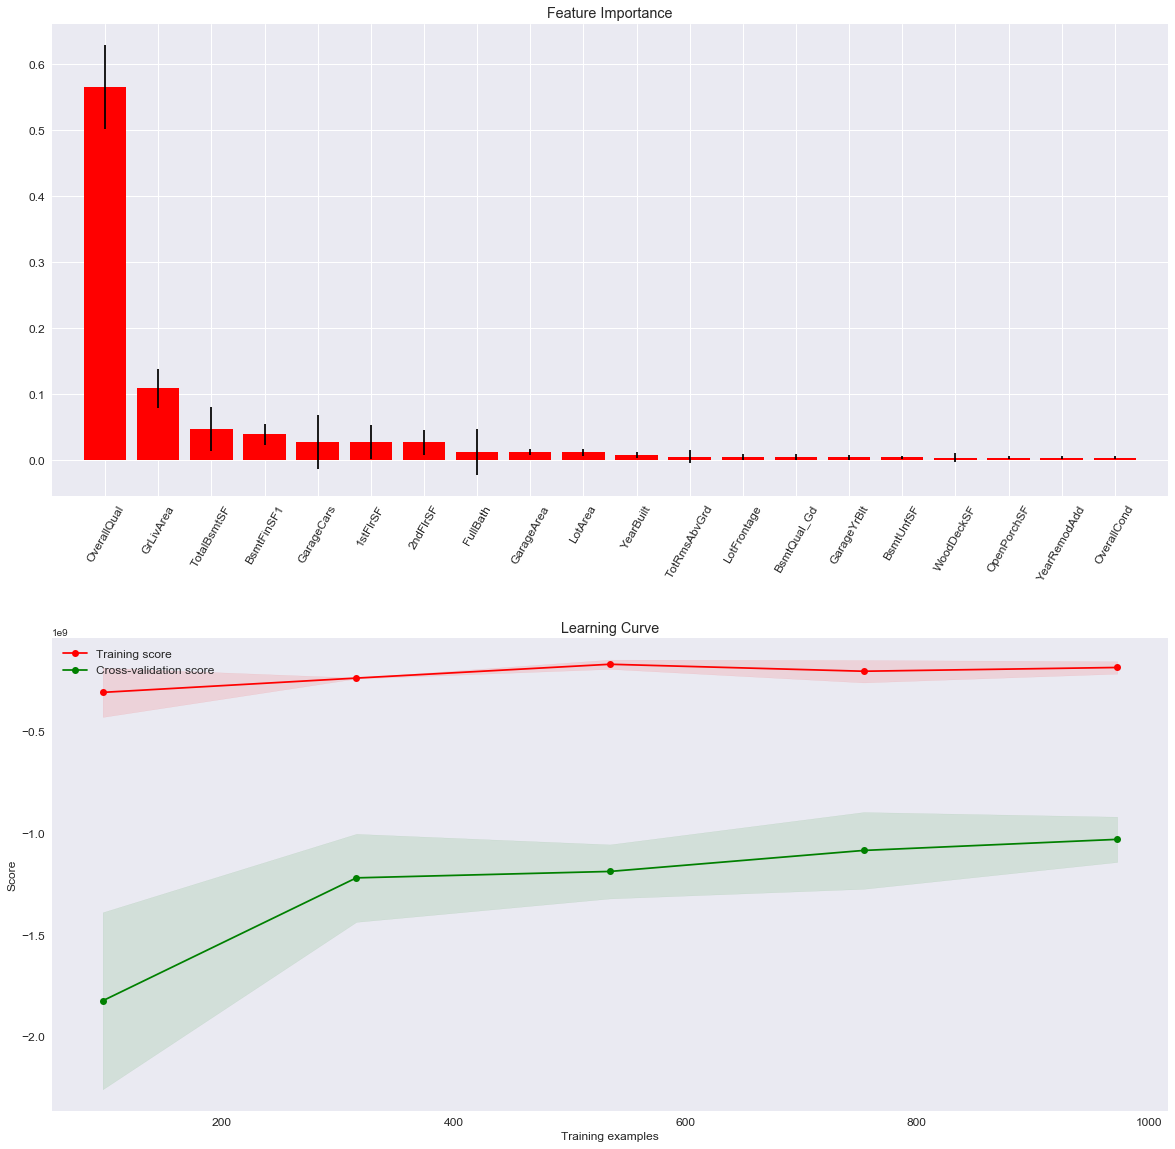

In [50]:
forest_errors = measure_regression_model(forest_model, forest_scores, train, train_prepared, "SalePrice", labels, 
                         features, scoring="neg_mean_squared_error", outlier_pipeline=None)

'Neighborhood' is of type object with 0 missing values


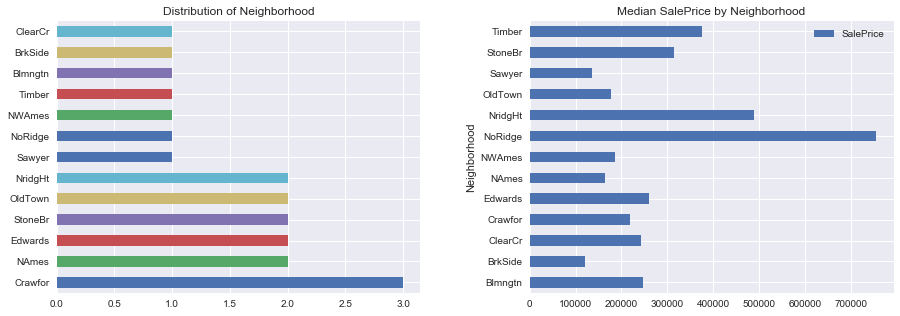

In [51]:
explore_variable(forest_errors[:20], "Neighborhood", "SalePrice")

'SalePrice' is of type int64 with 0 missing values


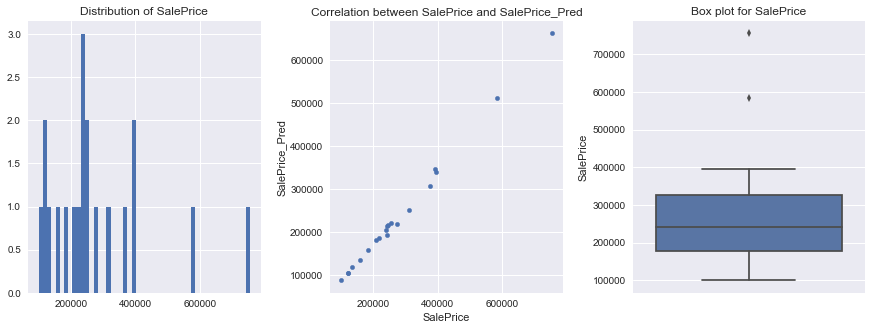

In [52]:
explore_variable(forest_errors[:20], "SalePrice", "SalePrice_Pred")

'YearBuilt' is of type int64 with 0 missing values


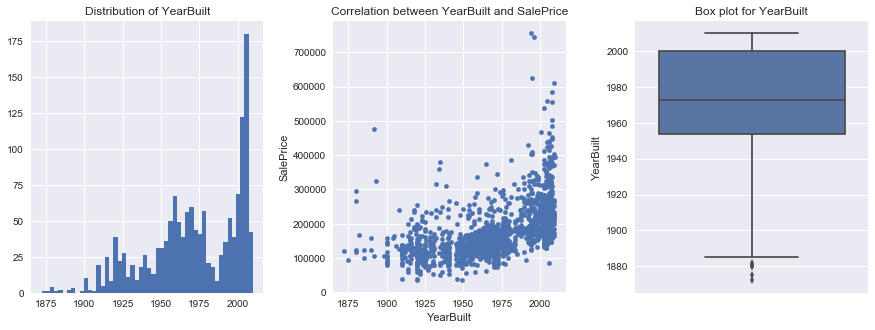

In [53]:
explore_variable(forest_errors, "YearBuilt", "SalePrice")

'YearRemodAdd' is of type int64 with 0 missing values


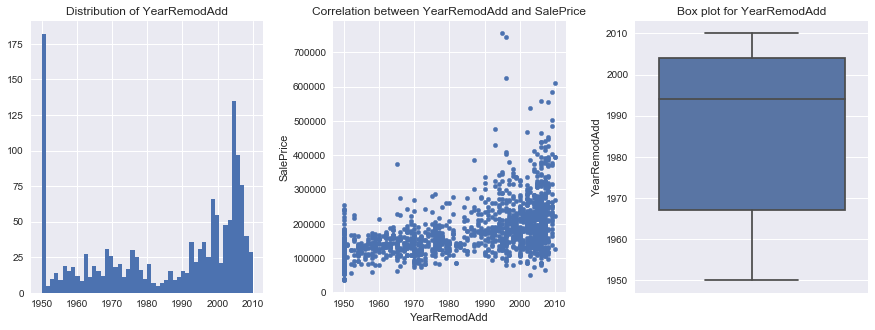

In [54]:
explore_variable(forest_errors, "YearRemodAdd", "SalePrice")

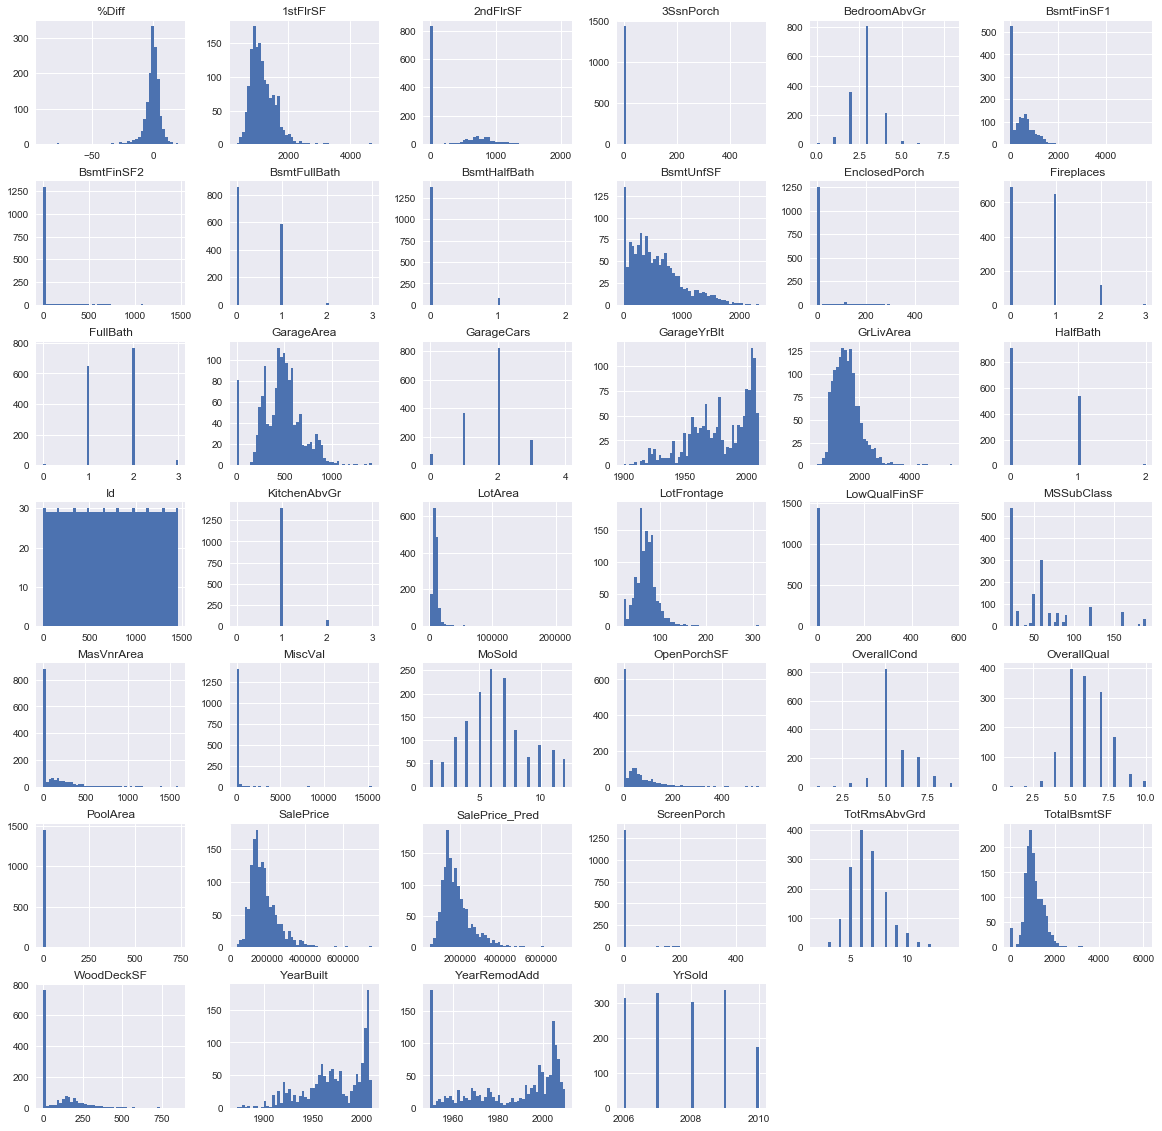

In [55]:
forest_errors.hist(bins=50, figsize=(20, 20))
plt.show()

## Addidtional Feature Selection & Engineering (1)

- Remove outliers (`1.5 IQR`) on SalePrice
- Convert `MSSubClass` to categorical
- Remove outliers on YearBuilt and add feature `YearSinceBuild` counting number of years since house was built
- Add features `HasRemod` == 1 if house has been remodelled and `YearSinceRemod` counting how many years since remodelling if `HasRemod` == 1. 
- Add `YearSoldSinceRemod` which gives the years between selling and remodelling.
- Remove all the year columns. 

In [56]:
housing = train.copy()

In [57]:
housing["MSSubClass"] = housing["MSSubClass"].astype('object');
housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,...,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,source
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,...,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,train
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,...,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,train
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,...,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,train
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,...,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,train
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,...,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,train


In [58]:
def calc_remod(row):
    return row["YearBuilt"] != row["YearRemodAdd"]

def calc_year_since_remod(row):
    if row["HasRemod"]:
        return row["YearRemodAdd"] - row["YearBuilt"]
    else:
        return 0
    
def calc_years_since_built(row):
    return row["YrSold"] - row["YearBuilt"]

def calc_years_sold_since_remod(row):
    if row["HasRemod"]:
        return row["YrSold"] - row["YearRemodAdd"]
    else:
        return 0

housing["HasRemod"] = housing.apply(calc_remod, axis=1)
housing["YearSinceRemod"] = housing.apply(calc_year_since_remod, axis=1)
housing["YearSinceBuild"] = housing.apply(calc_years_since_built, axis=1)
housing["YearSoldSinceRemod"] = housing.apply(calc_years_sold_since_remod, axis=1)
#housing.drop(["YearRemodAdd", "YearBuilt", "YrSold"], axis=1, inplace=True)
housing[["HasRemod", "YearSinceBuild", "YearSoldSinceRemod", "YearSinceRemod"]].head()

,HasRemod,YearSinceBuild,YearSoldSinceRemod,YearSinceRemod
0,False,5,0,0
1,False,31,0,0
2,True,7,6,1
3,True,91,36,55
4,False,8,0,0


In [67]:
outlier_params = {
    "features": ["SalePrice", "YearBuilt", "YearRemodAdd"], 
    "range": [1.5, 0.5, 1.5], 
    "remove_lows": [True, True, True],
    "remove_highs": [True, False, True]
}

outlier_pipeline = Pipeline([  
        ("outlier_removal", OutlierRemover(outlier_params)),        
])

num_pipelines = []
num_pipelines.append(('inf_imputer', InfImputer()))
num_pipelines.append(('num_imputer', Imputer(strategy="median")))
num_pipelines.append(('std_scaler', StandardScaler()))

cat_pipelines = []
cat_pipelines.append(("apply_na", ApplyNACategory(na_dict)))
cat_pipelines.append(("cat_imputer", MostFrequentImputer()))
cat_pipelines.append(("cat_encoder", OneHotEncoder(sparse=False)))

bool_pipelines = []
bool_pipelines.append(("bool_imputer", MostFrequentImputer()))

'YearBuilt' is of type int64 with 0 missing values


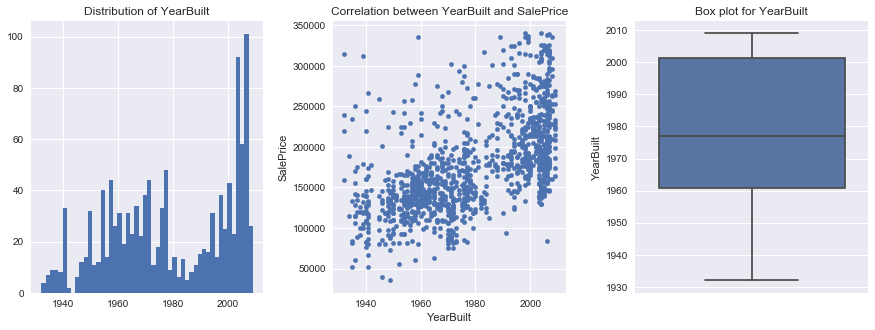

In [60]:
sample = outlier_pipeline.fit_transform(housing)
explore_variable(sample, "YearBuilt", "SalePrice")

'YearRemodAdd' is of type int64 with 0 missing values


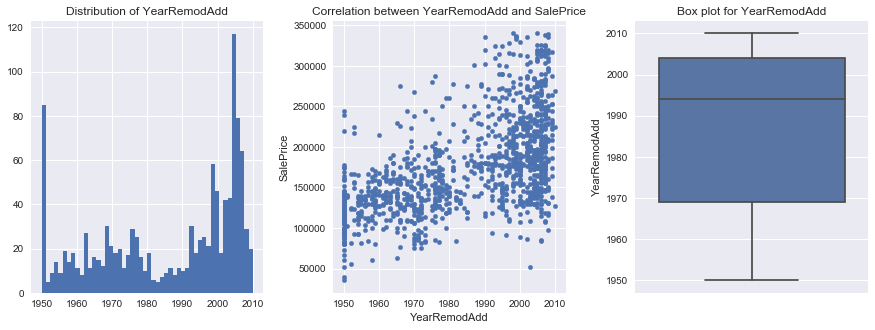

In [61]:
explore_variable(sample, "YearRemodAdd", "SalePrice")

In [75]:
forest_model_outliers_removed, train_prepared, labels, features, forest_scores_outliers_removed = build_run_model(RandomForestRegressor(random_state=42), housing, "SalePrice", num_pipelines, cat_pipelines, bool_pipelines, ["Id", "source", "YearBuilt", "YearRemodAdd"], outlier_pipeline, feature_list=None)




Removing features: ['Id', 'source', 'YearBuilt', 'YearRemodAdd']

Preparing data using transformation pipeline...
Data prepared

Fitting model to training data...

Running Cross-Validation...

CV complete




Model Report:

CV Score : Mean - 21549.041764 | Std - 2456.383013 | Min - 16587.732786 | Max - 24064.096051


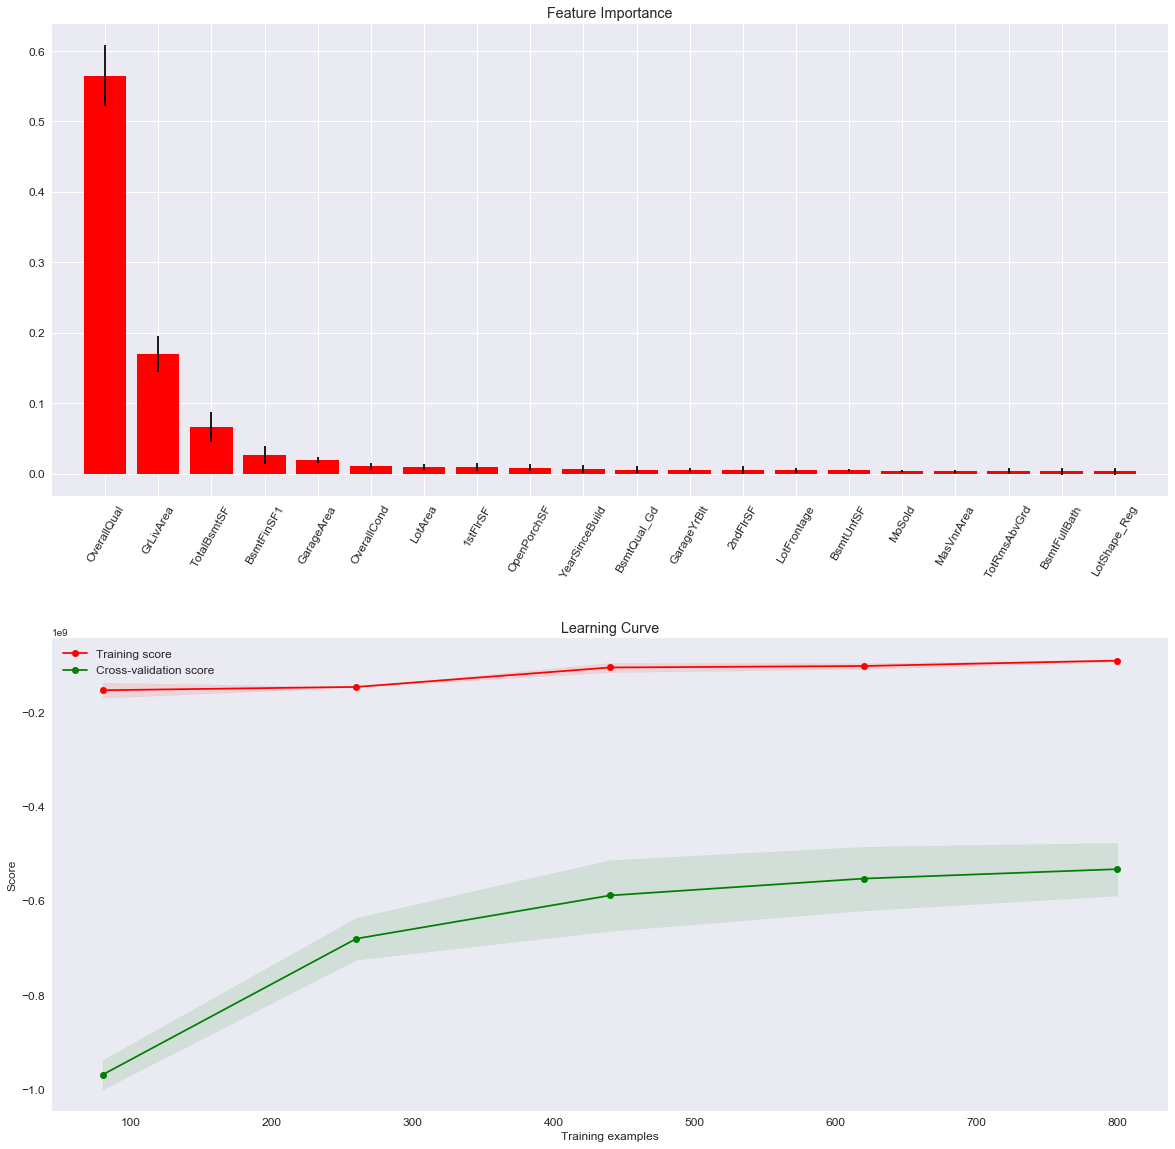

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,...,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,source,HasRemod,YearSinceRemod,YearSinceBuild,YearSoldSinceRemod,SalePrice_Pred,%Diff
271,272,20,RL,73.0,39104,Pave,NaN,IR1,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1Story,7,7,1954,2005,Flat,Membran,Plywood,Plywood,None,0.0,TA,TA,CBlock,...,Attchd,1954.0,Unf,2,439,TA,TA,Y,81,0,0,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Normal,241500,train,True,51,54,3,191739.5,20.604762
277,278,20,RL,140.0,19138,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,1Story,4,5,1951,1951,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,...,Detchd,1951.0,Unf,2,400,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,141000,train,False,0,59,0,113090.0,19.794326
218,219,50,RL,NaN,15660,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,1.5Fin,7,9,1939,2006,Gable,CompShg,VinylSd,VinylSd,BrkFace,312.0,Gd,Gd,CBlock,...,Attchd,1939.0,Unf,2,431,TA,TA,Y,0,119,150,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal,311500,train,True,67,69,2,252573.7,18.916950
613,614,20,RL,70.0,8402,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Feedr,Norm,1Fam,1Story,5,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,...,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,30,0,0,0,0,NaN,NaN,NaN,0,12,2007,New,Partial,147000,train,False,0,0,0,122850.0,16.428571
377,378,60,FV,102.0,11143,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Somerst,Norm,Norm,1Fam,2Story,8,5,2004,2005,Gable,CompShg,CemntBd,CmentBd,None,0.0,Gd,TA,PConc,...,Attchd,2004.0,RFn,2,610,TA,TA,Y,159,214,0,0,0,0,NaN,NaN,NaN,0,12,2007,WD,Normal,340000,train,True,1,3,2,285270.0,16.097059
13,14,20,RL,91.0,10652,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,7,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,Stone,306.0,Gd,TA,PConc,...,Attchd,2006.0,RFn,3,840,TA,TA,Y,160,33,0,0,0,0,NaN,NaN,NaN,0,8,2007,New,Partial,279500,train,True,1,1,0,240790.0,13.849732
970,971,50,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1.5Fin,4,4,1949,1950,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,TA,CBlock,...,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,12,2006,WD,Abnorml,135000,train,True,1,57,56,117197.1,13.187333
454,455,90,RL,63.0,9297,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,Duplex,1Story,5,5,1976,1976,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,...,Detchd,1976.0,Unf,2,560,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,7,2006,WD,Family,188000,train,False,0,30,0,163790.0,12.877660
1212,1213,30,RL,50.0,9340,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,4,6,1941,1950,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,...,Attchd,1941.0,Unf,1,234,TA,TA,N,0,113,0,0,0,0,NaN,NaN,NaN,0,8,2009,WD,Normal,113000,train,True,9,68,59,98700.0,12.654867
400,401,120,RL,38.0,14963,Pave,NaN,IR2,Lvl,AllPub,Inside,Gtl,Veenker,Norm,Norm,TwnhsE,1Story,8,5,1996,1996,Gable,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,PConc,...,Attchd,1996.0,Fin,2,500,TA,TA,Y,120,30,0,0,224,0,NaN,NaN,NaN,0,12,2008,WD,Normal,245500,train,False,0,12,0,214690.0,12.549898


In [88]:
train_sorted = measure_regression_model(forest_model_outliers_removed, forest_scores_outliers_removed, housing, train_prepared, "SalePrice", labels, features, outlier_pipeline=outlier_pipeline)
train_sorted.head(20)


## Repeat Training & Performance Measurement (1)

This is looking better. Let's analyse the metrics again.

## Addidtional Feature Selection & Engineering (2)


## Repeat Training & Performance Measurement (2)

## Short-list Models

# Fine-Tune Models

## Random and Grid Search CV

## Ensemble Methods

# Performance on Test Set (1)

## Export Submission (1)

# Apply Neural Networks

# Further EDA using Best Features

# Key Findings & Conclusions